### **PINN eikonal based velocity inversion for crosshole tomopgraph of the SEAM model**

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
cd "/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_tomography_SEG2021"

/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_tomography_SEG2021


In [23]:
!pip install sciann
#!pip install sciann==0.5.4.0
#!pip install tensorflow==2.2.0
#!pip install keras==2.3.1 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [25]:
np.random.seed(123)
tf.random.set_seed(123)

In [26]:
#Model specifications

# Computational model parameters

zmin = 0.; zmax = 1.; deltaz = 0.01;
xmin = 0.; xmax = 1.; deltax = 0.01;


# Loading the velocity model
vel = np.load('./inputs/seam_model/vel_seam.npy')

# Point-source locations

sx = 0.
sz = np.round(np.arange(0,1.001,0.1),2);

# Number of training points
num_tr_pts = 4000

In [27]:
# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

Z,X,SZ = np.meshgrid(z,x,sz,indexing='ij')

SX = np.ones(SZ.shape)*sx # Creating an array of sources along z with same size as SX

# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel[...,np.newaxis],sz.size,axis=2)

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SZ.reshape(-1,1)] # Grid points for prediction 

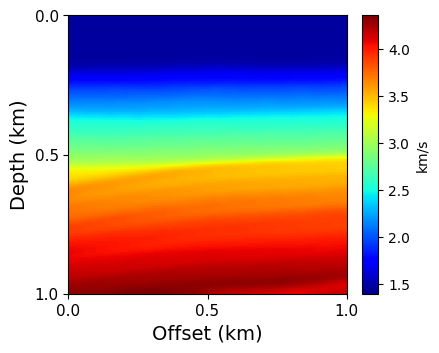

In [28]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.4,4.36)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/seam_model/v_true.pdf", format='pdf', bbox_inches="tight")

In [29]:
#selected_pts = np.random.choice(np.arange(Z.size),num_tr_pts,replace=False)
#Zf = Z.reshape(-1,1)[selected_pts]
#Zf1 = np.append(Zf,sz1)
#Zf2 = np.append(Zf,sz2)
#Xf = X.reshape(-1,1)[selected_pts]
#Xf1 = np.append(Xf,sx1)
#Xf2 = np.append(Xf,sx2)
#Tf1 = T_data1.reshape(-1,1)[selected_pts]
#Tf1 = np.append(Tf,0.)
#Tf1 = Tf1.reshape(-1,1)

#Tf2 = T_data2.reshape(-1,1)[selected_pts]
#Tf2 = np.append(Tf2,0.)
#Tf2 = Tf2.reshape(-1,1)

#X_starf1 = [Zf1.reshape(-1,1), Xf1.reshape(-1,1)] # Grid points for training

In [30]:
# Load traveltime solution

T_data = np.load('./inputs/seam_model/T_data.npy')
T_data.shape

(101, 101, 11)

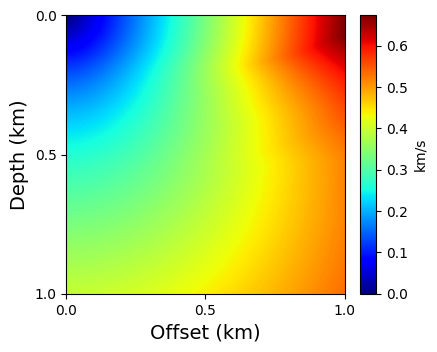

In [31]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(T_data[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/velmodel.pdf", format='pdf', bbox_inches="tight")

In [32]:
# Analytical solution for the known traveltime part

vs = velmodel[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0] # Velocity at the source location
T0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs;

px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

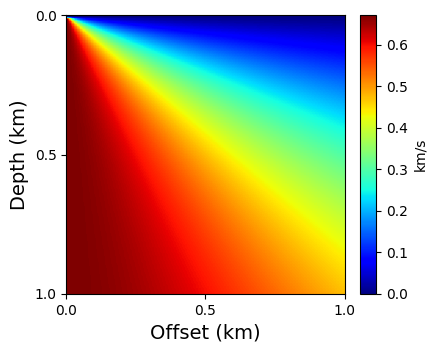

In [33]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(pz0[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/velmodel.pdf", format='pdf', bbox_inches="tight")

In [34]:
sz

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [35]:
# Find source location id in X_starf

TOLX = 1e-6
TOLZ = 1e-6

sids = np.array([]).astype(int)

for szi in sz:
    print(szi)
    sid,_ = np.where(np.logical_and(np.logical_and(np.abs(X_star[0]-szi)<TOLZ , np.abs(X_star[1]-sx)<TOLX), np.abs(X_star[2]-szi)<TOLX))
    sids = np.append(sids,sid)


print(sids)
print(sids.shape)
print(X_star[0][sids,0])
print(X_star[1][sids,0])
print(X_star[2][sids,0])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
[     0  11111  22222  33333  44444  55555  66666  77777  88888  99999
 111110]
(11,)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [36]:
# Locations to read tau 
#inv_ids,_ = np.where(np.logical_or(np.logical_or(np.abs(X_star[0]-0.)<TOLZ,np.abs(X_star[1]-0.)<TOLX),np.abs(X_star[1]-3.)<TOLX))

inv_ids,_ = np.where(np.abs(X_star[1]-1.)<TOLX)

#Taking every other grid point as receiver
inv_ids = inv_ids[::2]

#print(inv_ids)
print(inv_ids.shape)

(556,)


In [37]:
# Preparing the Sciann model object

K.clear_session() 

layers = [20]*10 

velmodel = velmodel.reshape(-1,1)

px0 = px0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)

T_data = T_data.reshape(-1,1)


xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
szt = Variable("szt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')

# Constant model for vt
# vt = sn.Parameter(...)
# Linear model for vt (no hidden layers) 
import sciann as sn
#xtf = sn.math.fourier(xt,5)
#ztf = sn.math.fourier(zt,5) 
#sztf = sn.math.fourier(szt,5)

vt = Functional("vt", [zt, xt],[10]*10,'l-elu','sigmoid')*5

tau = Functional("tau", [zt, xt, szt], layers, 'l-elu','sigmoid')*5

delvt = diff(vt,xt)**2 + diff(vt,zt)**2

# Loss function based on the factored isotropic eikonal equation
L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2

#L = diff(tau, xt)**2 + diff(tau, zt)**2 - 1.0/vt**2

#targets = [tau, PDE(L), (1-sign(tau))*abs(tau), 5e-4*delvt**0.5]

targets = [tau, PDE(L)]

imposed_ids = np.append(sids,inv_ids)
imposed_tau = np.append(np.ones(sids.shape), T_data[inv_ids]/T0[inv_ids]).reshape(-1,1)
#imposed_tau = np.append(np.zeros(sids.shape), T_data[inv_ids]).reshape(-1,1)


target_vals = [(imposed_ids, imposed_tau),'zeros']

model = SciModel(
    [zt, xt, szt, pz0t, px0t, T0t], 
    targets#,load_weights_from='script3-end.hdf5'
)

In [38]:
# Evaluating initial velocity model and traveltimes

v_ini = vt.eval(model, X_star + [velmodel,pz0,px0,T0])
v_ini = v_ini.reshape(Z.shape)[:,:,0]


In [39]:
#Model training

start_time = time.time()
hist = model.train(
       X_star+[pz0,px0,T0],
       target_vals,
       batch_size = 1024,
       epochs = 250,
       learning_rate = 0.001,
       verbose=2,
       #adaptive_weights=10
       )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))


Total samples: 112211 
Batch size: 1024 
Total batches: 110 

Epoch 1/250
110/110 - 3s - loss: 0.4049 - mul_7_loss: 0.2342 - sub_1_loss: 0.1707
Epoch 2/250
110/110 - 1s - loss: 0.0249 - mul_7_loss: 0.0161 - sub_1_loss: 0.0088
Epoch 3/250
110/110 - 1s - loss: 0.0066 - mul_7_loss: 0.0046 - sub_1_loss: 0.0019
Epoch 4/250
110/110 - 1s - loss: 0.0058 - mul_7_loss: 0.0041 - sub_1_loss: 0.0017
Epoch 5/250
110/110 - 1s - loss: 0.0055 - mul_7_loss: 0.0041 - sub_1_loss: 0.0014
Epoch 6/250
110/110 - 1s - loss: 0.0047 - mul_7_loss: 0.0034 - sub_1_loss: 0.0013
Epoch 7/250
110/110 - 1s - loss: 0.0048 - mul_7_loss: 0.0036 - sub_1_loss: 0.0012
Epoch 8/250
110/110 - 1s - loss: 0.0045 - mul_7_loss: 0.0033 - sub_1_loss: 0.0011
Epoch 9/250
110/110 - 1s - loss: 0.0043 - mul_7_loss: 0.0031 - sub_1_loss: 0.0012
Epoch 10/250
110/110 - 1s - loss: 0.0042 - mul_7_loss: 0.0031 - sub_1_loss: 0.0012
Epoch 11/250
110/110 - 1s - loss: 0.0039 - mul_7_loss: 0.0028 - sub_1_loss: 0.0011
Epoch 12/250
110/110 - 1s - loss:

In [40]:
#Model training using L-BFGS-B

model = SciModel(
    [zt, xt, szt,pz0t,px0t,T0t], 
    targets, optimizer='scipy-l-BFGS-B'
)

start_time = time.time()
hist = model.train(
       X_star + [pz0,px0,T0],
       target_vals,
       batch_size = X_star[0].size,
       epochs = 1000,
       learning_rate = 0.001,
       verbose=2,
       #adaptive_weights=10,
       save_weights_to='models/seam',
       save_weights_freq=1e8
       )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

Streaming output truncated to the last 5000 lines.
itr: 444 loss: 3.3596e-05, mul_7_loss: 1.5470e-05, sub_1_loss: 1.8126e-05
itr: 444 loss: 3.3536e-05, mul_7_loss: 1.5473e-05, sub_1_loss: 1.8063e-05
itr: 445 loss: 3.3521e-05, mul_7_loss: 1.5444e-05, sub_1_loss: 1.8077e-05
itr: 446 loss: 3.3510e-05, mul_7_loss: 1.5425e-05, sub_1_loss: 1.8085e-05
itr: 447 loss: 3.3498e-05, mul_7_loss: 1.5412e-05, sub_1_loss: 1.8086e-05
itr: 448 loss: 3.3465e-05, mul_7_loss: 1.5402e-05, sub_1_loss: 1.8063e-05
itr: 449 loss: 3.3431e-05, mul_7_loss: 1.5407e-05, sub_1_loss: 1.8024e-05
itr: 450 loss: 3.3400e-05, mul_7_loss: 1.5423e-05, sub_1_loss: 1.7978e-05
itr: 451 loss: 3.3383e-05, mul_7_loss: 1.5427e-05, sub_1_loss: 1.7956e-05
itr: 452 loss: 3.3358e-05, mul_7_loss: 1.5443e-05, sub_1_loss: 1.7915e-05
itr: 453 loss: 3.3337e-05, mul_7_loss: 1.5446e-05, sub_1_loss: 1.7890e-05
itr: 454 loss: 3.3295e-05, mul_7_loss: 1.5433e-05, sub_1_loss: 1.7863e-05
itr: 455 loss: 3.3278e-05, mul_7_loss: 1.5409e-05, sub_1_loss

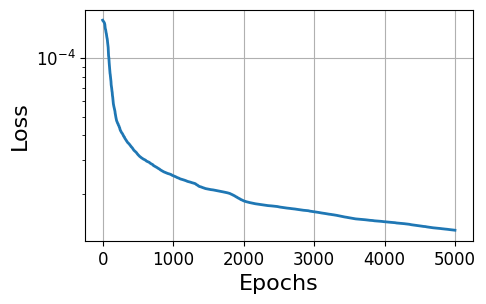

In [41]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'],LineWidth=2)

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12);
plt.grid()

In [42]:
tau_pred = tau.eval(model, X_star + [velmodel,pz0,px0,T0])
T_pred = tau_pred*T0

T_pred = T_pred.reshape(Z.shape)

v_pred = vt.eval(model, X_star + [velmodel,pz0,px0,T0])
v_pred = v_pred.reshape(Z.shape)[:,:,0]

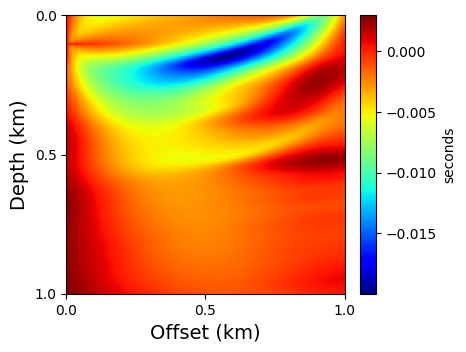

In [43]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(T_pred[:,:,1]-T_data.reshape(Z.shape)[:,:,1], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./figs/vofz/pinnerror.pdf", format='pdf', bbox_inches="tight")

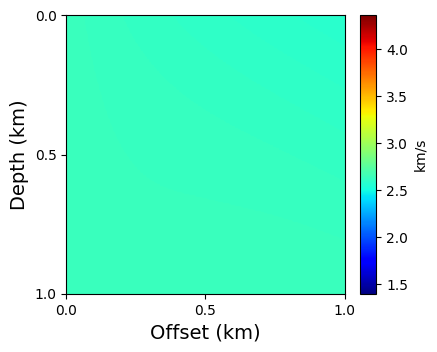

In [44]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(v_ini, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(1.4,4.36)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/seam_model/vel_ini.pdf", format='pdf', bbox_inches="tight")

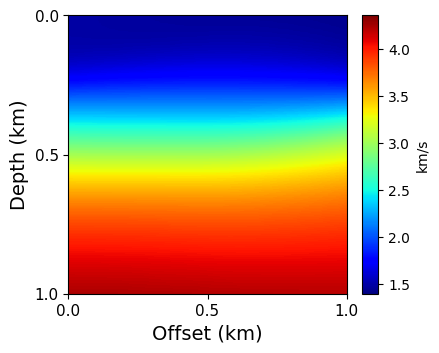

In [45]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(v_pred, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.mappable.set_clim(1.4,4.36)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/seam_model/vel_inv.pdf", format='pdf', bbox_inches="tight")

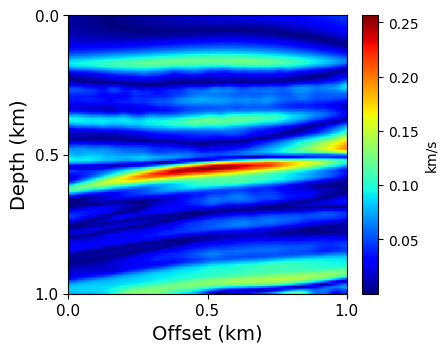

In [46]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(v_pred-velmodel.reshape(Z.shape)[:,:,0]), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/seam_model/pinnerror.pdf", format='pdf', bbox_inches="tight")

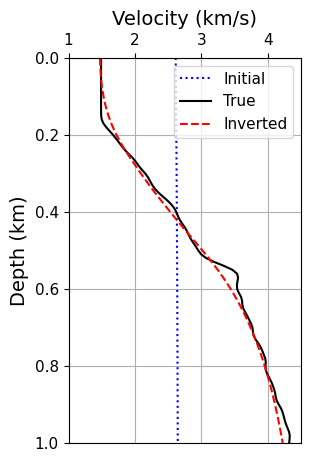

In [47]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')

v_true = velmodel.reshape(Z.shape)[:,:,0]

plt.plot(v_ini[:,40],z,'b:')
plt.plot(v_true[:,40],z,'k')
plt.plot(v_pred[:,40],z,'r--')

ax.set_title('Velocity (km/s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.ylim([0,1])
plt.xlim([1.,4.5])

plt.gca().invert_yaxis()

plt.legend(['Initial','True','Inverted'], fontsize=11)

plt.grid()

plt.savefig("./figs/seam_model/vel_trace1.pdf", format='pdf', bbox_inches="tight")

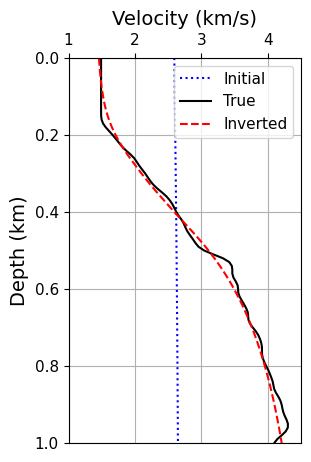

In [48]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')

v_true = velmodel.reshape(Z.shape)[:,:,0]

plt.plot(v_ini[:,80],z,'b:')
plt.plot(v_true[:,80],z,'k')
plt.plot(v_pred[:,80],z,'r--')


ax.set_title('Velocity (km/s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.ylim([0,1])
plt.xlim([1.,4.5])

plt.gca().invert_yaxis()

plt.legend(['Initial','True','Inverted'], fontsize=11)#loc='upper right')

plt.grid()

plt.savefig("./figs/seam_model/vel_trace2.pdf", format='pdf', bbox_inches="tight")

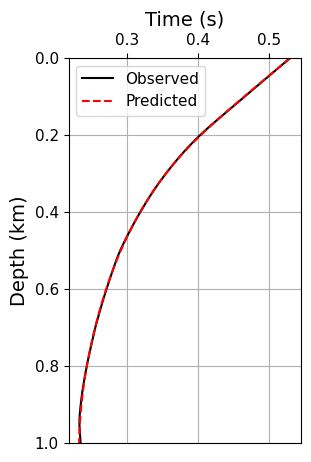

In [49]:
plt.style.use('default')

plt.figure(figsize=(3,5))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

ax = plt.gca()
#ax.xaxis.set_tick_params(labeltop='on')


plt.plot(T_data.reshape(Z.shape)[:,-1,10],z,'k-')
plt.plot(T_pred.reshape(Z.shape)[:,-1,10],z,'r--')


ax.set_title('Time (s)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=11)

plt.ylim([0,1])
#plt.xlim([1.25,4.5])

plt.gca().invert_yaxis()

plt.legend(['Observed','Predicted'],fontsize=11)

plt.grid()

plt.savefig("./figs/seam_model/data_fit1.pdf", format='pdf', bbox_inches="tight")

In [50]:
np.min(v_ini)

2.582882001861717